In [1]:
import torch
from data.sampleable import MNISTSampler, GaussianConditionalProbabilityPath
from data.alpha_beta import LinearAlpha, LinearBeta
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def train_data(device):
        
    num_rows = 3
    num_cols = 3
    num_timesteps = 5

    # Initialize our sampler
    sampler = MNISTSampler().to(device)

    # Initialize probability path
    path = GaussianConditionalProbabilityPath(
        p_data = sampler,
        p_simple_shape = [1, 32, 32],
        alpha = LinearAlpha(),
        beta = LinearBeta()
    ).to(device)

    # Sample 
    num_samples = num_rows * num_cols
    z, _ = path.p_data.sample(num_samples)
    z = z.view(-1, 1, 32, 32)

    # Setup plot
    _, axes = plt.subplots(1, num_timesteps, figsize=(6 * num_cols * num_timesteps, 6 * num_rows))

    # Sample from conditional probability paths and graph
    ts = torch.linspace(0, 1, num_timesteps).to(device)
    for tidx, t in enumerate(ts):
        tt = t.view(1,1,1,1).expand(num_samples, 1, 1, 1) # (num_samples, 1, 1, 1)
        xt = path.sample_conditional_path(z, tt) # (num_samples, 1, 32, 32)
        grid = make_grid(xt, nrow=num_cols, normalize=True, value_range=(-1,1))
        axes[tidx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
        axes[tidx].axis("off")
    plt.show()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from model.mnist_unet import MNISTUNet
from train.trainer import CFGTrainer
from data.sampleable import GaussianConditionalProbabilityPath

path = GaussianConditionalProbabilityPath(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    alpha = LinearAlpha(),
    beta = LinearBeta()
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 2,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = CFGTrainer(path = path, model = unet, eta=0.1)

# Train!
losses = trainer.train(num_epochs = 1000, device=device, lr=1e-3, batch_size=250)

# plot the losses
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

KeyboardInterrupt: 

In [1]:
from data.simulator import CFGVectorFieldODE, EulerSimulator

# Play with these!
samples_per_class = 10
num_timesteps = 50
guidance_scales = [0.1, 0.5, 1.0, 5.0, 10.0, 100.0]

# Graph
fig, axes = plt.subplots(1, len(guidance_scales), figsize=(10 * len(guidance_scales), 10))

for idx, w in enumerate(guidance_scales):
    # Setup ode and simulator
    ode = CFGVectorFieldODE(unet, guidance_scale=w)
    simulator = EulerSimulator(ode)

    # Sample initial conditions
    y = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=torch.int64).repeat_interleave(samples_per_class).to(device)
    num_samples = y.shape[0]
    x0, _ = path.p_simple.sample(num_samples) # (num_samples, 1, 32, 32)

    # Simulate
    ts = torch.linspace(0,1,num_timesteps).view(1, -1, 1, 1, 1).expand(num_samples, -1, 1, 1, 1).to(device)
    x1 = simulator.simulate(x0, ts, y=y)

    # Plot
    grid = make_grid(x1, nrow=samples_per_class, normalize=True, value_range=(-1,1))
    axes[idx].imshow(grid.permute(1, 2, 0).cpu(), cmap="gray")
    axes[idx].axis("off")
    axes[idx].set_title(f"Guidance: $w={w:.1f}$", fontsize=25)
plt.show()

NameError: name 'plt' is not defined

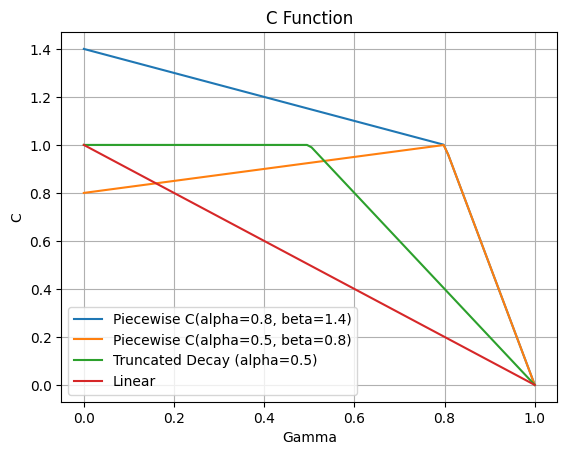

In [ ]:
# plot the c function
import matplotlib.pyplot as plt
from train.c_functions import PiecewiseC, TruncatedDecayC, LinearC

gamma = torch.linspace(0, 1, 100)
c = PiecewiseC(alpha=0.8, beta=1.4)(gamma)
plt.plot(gamma, c, label=f"Piecewise C(alpha={0.8}, beta={1.4})")


c = PiecewiseC(alpha=0.8, beta=0.8)(gamma)
plt.plot(gamma, c, label=f"Piecewise C(alpha={0.5}, beta={0.8})")

c = TruncatedDecayC(alpha=0.5)(gamma)
plt.plot(gamma, c, label="Truncated Decay (alpha=0.5)")

c = LinearC()(gamma)
plt.plot(gamma, c, label="Linear")

plt.legend()
# add grid
plt.grid(True)
# add title and axis labels
plt.title("C Function")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.show()


In [ ]:
from model.mnist_unet import MNISTUNet
from train.trainer import EqMTrainer
from data.sampleable import GaussianEqM, MNISTSampler
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path = GaussianEqM(
    p_data = MNISTSampler(),
    p_simple_shape = [1, 32, 32],
    grad_magnitude_func = TruncatedDecayC(alpha=0.8)
).to(device)

# Initialize model
unet = MNISTUNet(
    channels = [32, 64, 128],
    num_residual_layers = 3,
    t_embed_dim = 40,
    y_embed_dim = 40,
)

# Initialize trainer
trainer = EqMTrainer(data_sampler = path, model = unet, device=device)

# Train!
losses = trainer.train(num_epochs = 1000, device=device, lr=1e-3, batch_size=250)

Training model with size: 6.718 MiB


Epoch 999, loss: 2.072: : 1000it [01:35, 10.45it/s]


Text(0.5, 1.0, 'Training Loss')

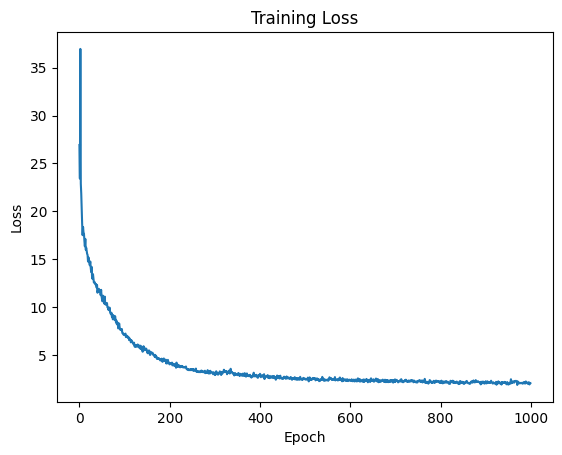

In [6]:
# plot the losses
from matplotlib import pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

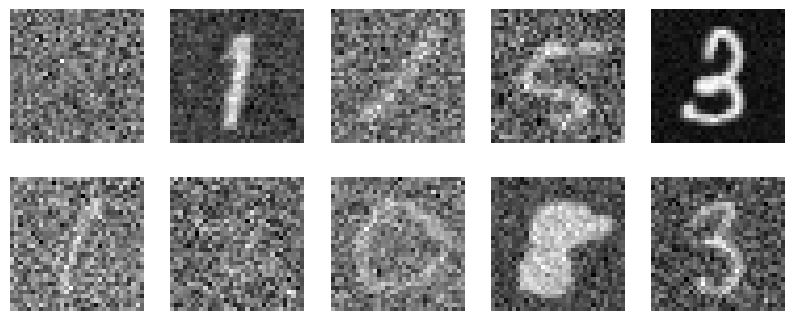

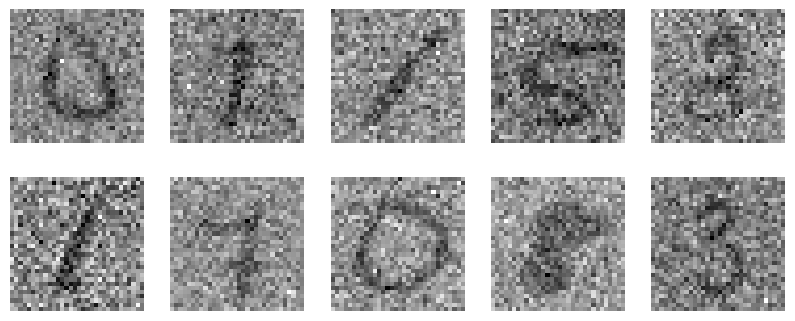

In [7]:
gamma = torch.rand(10, 1, 1, 1).to(device)
samples, target, y = path.sample_conditional_path(torch.rand(10, 1, 1, 1).to(device))

# plot the samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = samples[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()

# plot the target
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(10):
    img = target[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()

0.0
0.10919950902462006
0.2183990180492401
0.32759854197502136
0.4367980360984802
0.5459975600242615
0.6551970839500427
0.7643965482711792
0.8735960721969604
0.9827954769134521


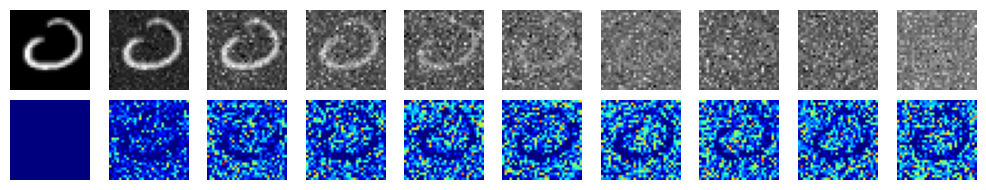

In [8]:
from matplotlib import pyplot as plt

def show_sample_path(path : GaussianEqM, num_steps : int = 10):
    """
    Show the progression of a sample from original image to final noised image.
    """
    # get many gammas of increasing magnitude
    data, _ = path.p_data.sample(1)
    gamma = torch.rand_like(data) * 2.2
    # duplicate the noise 100 times
    gammas = gamma.repeat(num_steps, 1, 1, 1)
    _, target = path._apply_noise(data, gammas[-1])
    v_min = float('inf')
    v_max = -float('inf')
    
    targets = []
    noised_samples = []
    for i, gamma in enumerate(gammas):
        # scale the noise 
        scaler = (i) / num_steps
        av_noise_noise = torch.mean(gamma * scaler)
        print(av_noise_noise.item())
        xg, target = path._apply_noise(data, 1-(gamma.abs() * scaler))
        targets.append(target.detach().cpu())
        noised_samples.append(xg.detach().cpu())
        
        # update the min and max
        v_min = min(v_min, target.abs().min().item())
        v_max = max(v_max, target.abs().max().item())

    # plot the samples and targets
    fig, axes = plt.subplots(2, num_steps, figsize=(10, 2))
    # plot the original image
    for i in range(num_steps):
        img = noised_samples[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
        axes[0,i].imshow(img, cmap="gray")
        axes[0,i].axis("off")

    for i in range(num_steps):
        img = targets[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
        axes[1,i].imshow(img, cmap="jet", vmin=v_min, vmax=v_max)
        axes[1,i].axis("off")
    
    plt.tight_layout()
    plt.show()
show_sample_path(path, 10)

Sampling...


Step 31 0 / 10, GN: 16.019:  32%|███▏      | 32/100 [00:05<00:10,  6.40it/s]  


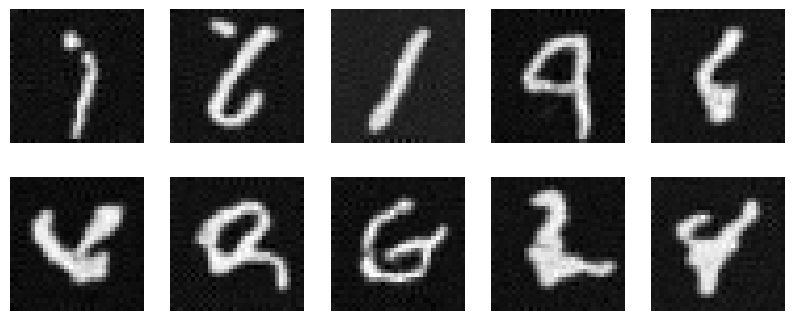

In [33]:
from matplotlib import pyplot as plt
from tqdm import tqdm

def cfe_grad(model, x, t, y, guidance_scale = 5.0):
    guided_grad = model(x, t, y)
    unguided_grad = model(x, t, torch.ones_like(y) * 10)
    return (1 - guidance_scale) * unguided_grad + guidance_scale * guided_grad

def sample_EqM(model, st, step_size, nag_factor, g_threshold, max_steps = 50, target_y = 1, guidance_scale = 5.0):
    model = model.eval()
    x = st
    x_last = st
    y = torch.ones(st.shape[0]).to(st.device).int() * target_y
    t = torch.zeros(st.shape[0], 1, 1, 1).to(st.device)
    grad = cfe_grad(model, st, t, y, guidance_scale)
    
    step = 0
    norm_grad = torch.norm(grad)
    pbar = tqdm(range(max_steps))
    sample_update_mask = torch.ones_like(y)
    intermediate_steps = []
    
    while sum(sample_update_mask) > 0 and step < max_steps:
        
        x_last = x
        x = x - step_size * grad * sample_update_mask.view(-1, 1, 1, 1)
        new_input = x + nag_factor*(x-x_last)
        grad = cfe_grad(model, new_input, t, y)
        norm_grad = torch.linalg.matrix_norm(grad)
        sample_update_mask = norm_grad > g_threshold
        pbar.set_description(f'Step {step} {sum(sample_update_mask).item()} / {st.shape[0]}, GN: {norm_grad.mean().item():.3f}')
        step += 1
        pbar.update(1)
        intermediate_steps.append(x_last)
    return x_last, intermediate_steps

unet.eval()
print('Sampling...')
result, intermediate_steps = sample_EqM(unet, 
                    path.p_simple.sample(10)[0], 
                    step_size=0.01, 
                    nag_factor=0.4,
                    g_threshold=20,
                    max_steps=100,
                    guidance_scale=0.0,
                    target_y=10)
# plot out the first 10 images as a grid
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    img = result[i].detach().cpu().view(1, 32, 32).squeeze().numpy()
    axes[i//5, i%5].imshow(img, cmap="gray")
    axes[i//5, i%5].axis("off")
plt.show()

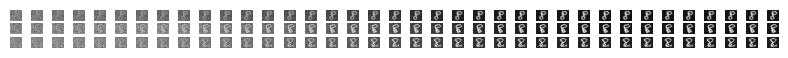

In [17]:
# plot out the path as a grid
fig, axes = plt.subplots(3, len(intermediate_steps), figsize=(10, 0.5))
for i in range(len(intermediate_steps)):
    for j in range(3):
        img = intermediate_steps[i][j].detach().cpu().view(1, 32, 32).squeeze().numpy()
        axes[j, i].imshow(img, cmap="gray")
        axes[j, i].axis('off')
plt.show()

# Also save the path as a video
import matplotlib.animation as animation

# Create figure and axes for animation
fig, ax = plt.subplots(figsize=(5, 5))
ax.axis('off')

# Function to update the frame
def animate(frame):
    ax.clear()
    ax.axis('off')
    img = intermediate_steps[frame][0].detach().cpu().view(1, 32, 32).squeeze().numpy()
    ax.imshow(img, cmap='gray')
    return [ax]

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(intermediate_steps), interval=100)

# Save as MP4
anim.save('optimization_path.mp4', writer='ffmpeg')
plt.close()

Classification:  1


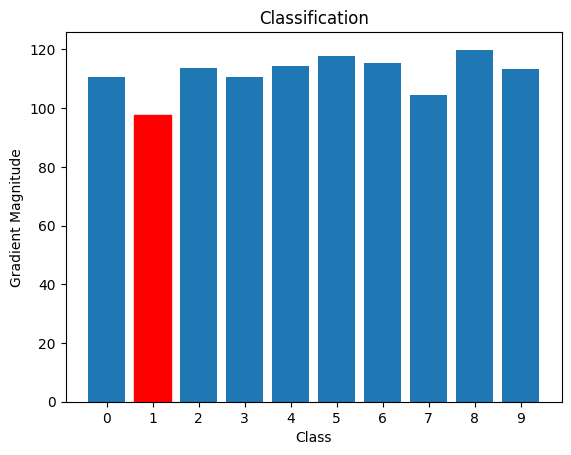

In [38]:
def classify_image(model : MNISTUNet, image : torch.Tensor):
    model = model.eval()
    x = image.view(1, 1, 32, 32)
    t = torch.zeros(1, 1, 1, 1).to(image.device)
    
    # repeat the image 10 times
    x = x.repeat(10, 1, 1, 1)
    y = torch.arange(10).to(image.device).int()
    guided_grad = model(x, t, y).squeeze()
    per_class_grad = torch.linalg.matrix_norm(guided_grad).detach().cpu().numpy()
    
    return per_class_grad

per_class_grad = classify_image(unet,result[3])
print('Classification: ', per_class_grad.argmin())
classification = per_class_grad.argmin()
y_to_classify = { i : per_class_grad[i] for i in range(10)}
# plot the classification
# show each bar label
barlist=plt.bar(y_to_classify.keys(), y_to_classify.values())
# color the bar of the classification a different color
barlist[classification].set_color('r')

plt.xticks(list(y_to_classify.keys()))
plt.xlabel('Class')
plt.ylabel('Gradient Magnitude')
plt.title('Classification')
plt.show()

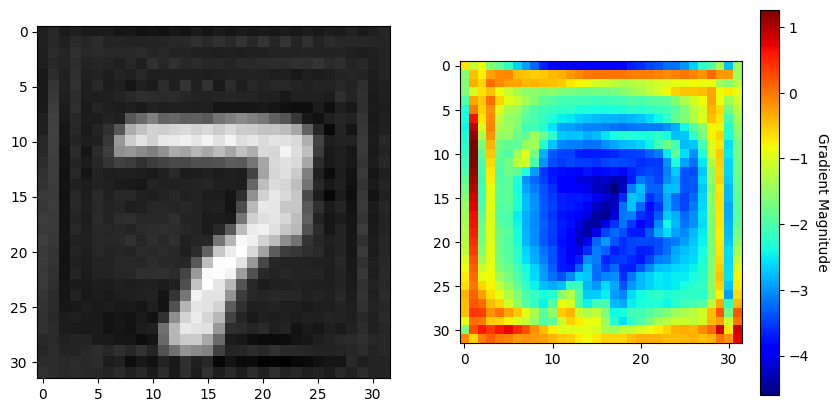

In [9]:
import numpy as np
# visualize the gradient
def visualize_grad(grad : np.ndarray, single_image : np.ndarray):
    # plot the gradient as a heatmap next to the image
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(single_image[0], cmap="gray")
    axes[1].imshow(grad, alpha=0.5, cmap="jet")
    # colorbar
    cbar = axes[1].figure.colorbar(axes[1].imshow(grad, cmap="jet"), ax=axes[1])
    cbar.ax.set_ylabel('Gradient Magnitude', rotation=-90, va="bottom")
    plt.show()
    
idx = 1
grad = unet(result[idx].view(1, 1, 32, 32), 
            torch.zeros(1, 1, 1, 1).to(result[8].device), 
            torch.ones(1).to(result[8].device).int() * 3).squeeze()

visualize_grad(grad.detach().cpu().numpy(), result[idx].detach().cpu().numpy())

Step 49 0 / 1, GN: 11.637: 100%|██████████| 50/50 [00:01<00:00, 31.38it/s]


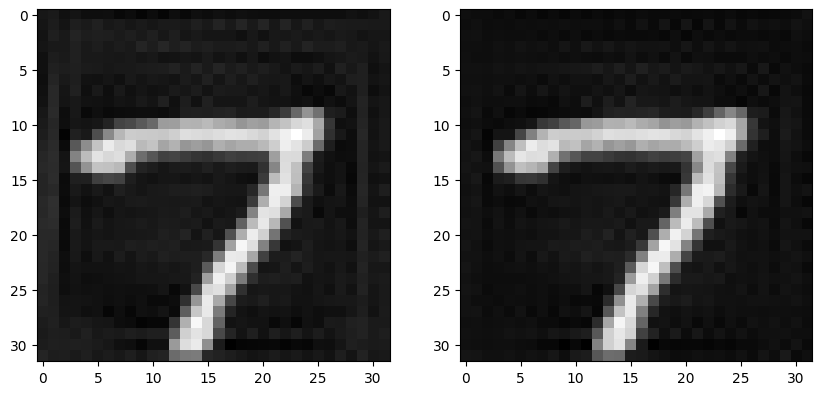

In [10]:
def transform_img(img : torch.Tensor, new_label : int, model : MNISTUNet, step_size = 0.01, nag_factor = 0.4, g_threshold = 12, max_steps = 50):
    # transform the image to the new label
    img = img.view(1, 1, 32, 32)
    t = torch.zeros(1, 1, 1, 1).to(img.device)
    y = torch.ones(1).to(img.device).int() * new_label
    step = 0
    x = img
    grad = cfe_grad(model, img, t, y, 1.0)
    
    step = 0
    pbar = tqdm(range(max_steps))
    sample_update_mask = torch.ones_like(y)
    while step < max_steps:
        
        x_last = x
        x = x - step_size * grad * sample_update_mask.view(-1, 1, 1, 1)
        new_input = x + nag_factor*(x-x_last)
        grad = cfe_grad(model, new_input, t, y)
        norm_grad = torch.linalg.matrix_norm(grad)
        sample_update_mask = norm_grad > g_threshold
        pbar.set_description(f'Step {step} {sum(sample_update_mask).item()} / {img.shape[0]}, GN: {norm_grad.mean().item():.3f}')
        step += 1
        pbar.update(1)

    return x_last

transformed = transform_img(result[0], 8, unet)

# plot the original and transformed image
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(result[0].detach().cpu().view(1, 32, 32).squeeze().numpy(), cmap="gray")
axes[1].imshow(transformed.detach().cpu().view(1, 32, 32).squeeze().numpy(), cmap="gray")
plt.show()

In [23]:
transformed

tensor([[[[-0.9639, -1.0540, -0.9735,  ..., -1.0537, -0.9104, -1.0010],
          [-0.9550, -0.9550, -1.0054,  ..., -0.9859, -1.0348, -1.0016],
          [-0.9878, -1.0111, -1.0120,  ..., -1.0548, -0.9601, -1.0087],
          ...,
          [-0.9836, -1.0061, -1.0127,  ..., -1.0067, -1.0184, -0.9760],
          [-1.0148, -0.9915, -0.9929,  ..., -0.9835, -0.9730, -0.9856],
          [-0.9942, -1.0139, -1.0118,  ..., -1.0306, -1.0020, -1.0174]]]],
       device='cuda:0', grad_fn=<SubBackward0>)